In [1]:
!pip install mediapipe numpy
!pip install tensorflow


In [2]:
# !pip install --upgrade --force-reinstall numpy mediapipe tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.8 MB/s eta 0:00:00
  Using cached mediapipe-0.10.21-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (9.7 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached sounddevice-0.5.1-py3-none-any.whl.metadata (1.4 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.9/101.9 kB 7.9 MB/s eta 0:00:00
Using cached mediapipe-0.10.21-cp311-cp311-manylinux_2_28_x86_64.whl (35.6 MB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 6.6 MB/s eta 0:00:00
   ━

In [2]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import numpy as np
import scipy
import os
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [3]:
# Google Drive setup
from google.colab import drive
drive.mount('/content/drive')
DRIVE_PATH = "/content/drive/mlp"

Mounted at /content/drive


In [4]:
cd /content/drive/MyDrive/

/content/drive/MyDrive


In [5]:
def save_video_reps(video_name, reps_data, save_dir='processed_data'):
    """
    Save rep data for a single video to a .npz file.

    Args:
        video_name (str): Name of the video file
        reps_data (list): List of numpy arrays containing rep data
        save_dir (str): Directory to save the .npz files
    """
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, video_name.replace('.mp4', '.npz'))
    save_dict = {f'rep_{i}': rep for i, rep in enumerate(reps_data)}
    np.savez_compressed(save_path, **save_dict)

def process_videos_directory(data_dir, save_dir='processed_data'):
    """
    Process all videos in directory, skipping those that already have .npz files.

    Args:
        data_dir (str): Directory containing videos
        save_dir (str): Directory to save processed data

    Returns:
        dict: Dictionary of processed videos and their rep data
    """
    os.makedirs(save_dir, exist_ok=True)
    all_sets_data = {}

    for file in os.listdir(data_dir):
        if file.endswith('.mp4'):
            npz_path = os.path.join(save_dir, file.replace('.mp4', '.npz'))

            if os.path.exists(npz_path):
                print(f"Skipping {file} - already processed")
                continue

            print(f"Processing {file}...")
            video_path = os.path.join(data_dir, file)
            set_data = extract_rep_joint_data(video_path)
            all_sets_data[file] = set_data

            # Save the processed data
            save_video_reps(file, set_data, save_dir)
            print(f"Found and saved {len(set_data)} reps for {file}")

    return all_sets_data

def save_existing_reps_data(all_reps_data, save_dir='processed_data'):
    """
    Save any rep data currently in memory that hasn't been saved yet.

    Args:
        all_reps_data (dict): Dictionary mapping video names to rep data
        save_dir (str): Directory to save processed data
    """
    os.makedirs(save_dir, exist_ok=True)

    for video_name, set_data in all_reps_data.items():
        npz_path = os.path.join(save_dir, video_name.replace('.mp4', '.npz'))
        if not os.path.exists(npz_path):
            print(f"Saving data for {video_name}...")
            save_video_reps(video_name, set_data, save_dir)

import numpy as np

def load_all_processed_data(processed_dir='processed_data'):
    """
    Load all processed rep data from .npz files in directory.

    Returns:
        dict: Dictionary mapping video names to a list of rep arrays.
              Each rep array should ideally have shape (timesteps, 4).
    """
    all_sets_data = {}

    for file in os.listdir(processed_dir):
        if file.endswith('.npz'):
            video_name = file.replace('.npz', '.mp4')
            npz_path = os.path.join(processed_dir, file)

            loaded = np.load(npz_path)
            rep_keys = [k for k in loaded.files if k.startswith('rep_')]
            rep_keys.sort(key=lambda x: int(x.split('_')[1])) # Sort based on rep number

            reps = [loaded[key] for key in rep_keys]

            # Print shape of each rep
            for i, rep in enumerate(reps):
                print(f"Rep {i} shape for {video_name}: {rep.shape}")

            all_sets_data[video_name] = reps
            print(f"Loaded {len(reps)} reps from {video_name}")

    return all_sets_data


In [6]:
import numpy as np

def prepare_rep_for_lstm_quantiles(rep_data, fps=30, num_quantiles=5):
    """
    Prepares a single repetition's joint data for LSTM input by:
    1. Computing ROM (Range of Motion)
    2. Computing velocities
    3. Extracting values at specific quantiles (1/5, 2/5, 3/5, 4/5, 5/5)

    Args:
        rep_data (np.ndarray): Array of shape (timesteps, 4) containing
                              [elbow_x, elbow_y, wrist_x, wrist_y]
        fps (int): Frames per second of the video
        num_quantiles (int): Number of quantiles to extract (default: 5)

    Returns:
        np.ndarray: Processed features of shape (num_quantiles, n_features)
                   Features: [norm_elbow_x, norm_elbow_y, norm_wrist_x, norm_wrist_y,
                            elbow_velocity, wrist_velocity, rom_percentage]
    """

    normalized_coords = rep_data

    # 2. Calculate ROM (Range of Motion)
    wrist_to_elbow = np.sqrt(
        (rep_data[:, 2] - rep_data[:, 0])**2 +
        (rep_data[:, 3] - rep_data[:, 1])**2
    )
    rom = wrist_to_elbow - np.min(wrist_to_elbow)
    rom_percentage = rom / np.max(rom)

    # 3. Calculate velocities (change in position per frame)
    dt = 1/fps
    elbow_velocity = np.sqrt(
        np.gradient(normalized_coords[:, 0])**2 +
        np.gradient(normalized_coords[:, 1])**2
    ) / dt
    wrist_velocity = np.sqrt(
        np.gradient(normalized_coords[:, 2])**2 +
        np.gradient(normalized_coords[:, 3])**2
    ) / dt

    # 4. Extract values at quantiles
    quantile_indices = np.round(np.linspace(0, len(rep_data) - 1, num_quantiles)).astype(int)

    # Extract the values at those indices from the calculated features
    selected_coords = normalized_coords[quantile_indices]
    selected_elbow_velocity = elbow_velocity[quantile_indices]
    selected_wrist_velocity = wrist_velocity[quantile_indices]
    selected_rom_percentage = rom_percentage[quantile_indices]

    # Combine selected features
    features = np.column_stack([
        selected_coords,
        selected_elbow_velocity,
        selected_wrist_velocity,
        selected_rom_percentage
    ])

    return features

In [7]:
all_sets = load_all_processed_data("./processed_npzs")

Rep 0 shape for t5.mp4: (70, 4)
Rep 1 shape for t5.mp4: (72, 4)
Rep 2 shape for t5.mp4: (80, 4)
Rep 3 shape for t5.mp4: (88, 4)
Rep 4 shape for t5.mp4: (71, 4)
Rep 5 shape for t5.mp4: (73, 4)
Rep 6 shape for t5.mp4: (74, 4)
Rep 7 shape for t5.mp4: (72, 4)
Rep 8 shape for t5.mp4: (73, 4)
Rep 9 shape for t5.mp4: (76, 4)
Rep 10 shape for t5.mp4: (75, 4)
Rep 11 shape for t5.mp4: (73, 4)
Rep 12 shape for t5.mp4: (76, 4)
Rep 13 shape for t5.mp4: (75, 4)
Rep 14 shape for t5.mp4: (77, 4)
Rep 15 shape for t5.mp4: (89, 4)
Rep 16 shape for t5.mp4: (99, 4)
Rep 17 shape for t5.mp4: (102, 4)
Rep 18 shape for t5.mp4: (101, 4)
Loaded 19 reps from t5.mp4
Rep 0 shape for t1.mp4: (83, 4)
Rep 1 shape for t1.mp4: (85, 4)
Rep 2 shape for t1.mp4: (83, 4)
Rep 3 shape for t1.mp4: (81, 4)
Rep 4 shape for t1.mp4: (79, 4)
Rep 5 shape for t1.mp4: (81, 4)
Rep 6 shape for t1.mp4: (80, 4)
Rep 7 shape for t1.mp4: (86, 4)
Rep 8 shape for t1.mp4: (85, 4)
Rep 9 shape for t1.mp4: (104, 4)
Rep 10 shape for t1.mp4: (118, 4)

In [8]:
import pandas as pd

# Get the first video name from all_sets
first_video_name = list(all_sets.keys())[0]

# Get the first repetition from that video
first_rep = all_sets[first_video_name][0]

# Define column names based on the data structure
column_names = ['Elbow X', 'Elbow Y', 'Wrist X', 'Wrist Y']

# Create a DataFrame
df = pd.DataFrame(first_rep, columns=column_names)

# Display the DataFrame
print(f"Video: {first_video_name}, Rep: 0")
display(df)

Video: t5.mp4, Rep: 0


,Elbow X,Elbow Y,Wrist X,Wrist Y
0,-32.849711,301.798477,-84.894519,592.040863
1,-32.262540,304.628983,-87.221776,586.042099
2,-31.830985,306.992950,-90.617451,583.927536
3,-29.752194,307.334251,-93.051273,579.384346
4,-26.948073,309.147377,-97.451389,574.656639
...,...,...,...,...
65,-32.713215,304.128494,-88.339811,560.171738
66,-33.598771,304.143448,-80.803860,562.846832
67,-33.927463,305.584412,-78.814667,571.009216
68,-34.841587,307.839203,-78.448866,576.889648


In [9]:
# 1) Prepare your data:
all_sets_list = list(all_sets.values())


In [10]:
import numpy as np
from scipy.interpolate import interp1d

def augment_time_series(data, speed_range=(0.9, 1.1), noise_std=0.01):
    """
    Augment a 7 x T time series by applying a random speed shift and jitter.

    Parameters:
        data (np.ndarray): Input array of shape (7, T)
        speed_range (tuple): Range for random speed multiplier (e.g., 0.9 to 1.1)
        noise_std (float): Standard deviation of Gaussian noise to add.

    Returns:
        np.ndarray: Augmented data of shape (7, T_augmented), where T_augmented is close to T.
    """
    num_channels, T = data.shape

    # 1. Time Warping (Speed Shifting)
    # Choose a random speed factor within the specified range.
    speed_factor = np.random.uniform(*speed_range)
    # Create new time indices.
    original_indices = np.arange(T)
    new_length = int(T / speed_factor)
    new_indices = np.linspace(0, T - 1, new_length)

    # Interpolate each channel to the new time indices.
    warped_data = np.zeros((num_channels, new_length))
    for i in range(num_channels):
        interp_func = interp1d(original_indices, data[i, :], kind='linear', fill_value="extrapolate")
        warped_data[i, :] = interp_func(new_indices)

    # If you want the output to be the same length T, you can re-interpolate back to T timesteps.
    re_indices = np.linspace(0, new_length - 1, T)
    warped_data_fixed = np.zeros((num_channels, T))
    for i in range(num_channels):
        interp_func = interp1d(np.arange(new_length), warped_data[i, :], kind='linear', fill_value="extrapolate")
        warped_data_fixed[i, :] = interp_func(re_indices)

    # 2. Jittering (Noise Injection)
    noise = np.random.normal(0, noise_std, size=warped_data_fixed.shape)
    augmented_data = warped_data_fixed + noise

    return augmented_data

In [11]:
print(list(all_sets.keys()))
print(len(list(all_sets.keys())))

['t5.mp4', 't1.mp4', 't2.mp4', '5_l.mp4', '14r (1).mp4', '11r (1).mp4', '12r (1).mp4', '5_r.mp4', '10r (1).mp4', '8_r (1).mp4', 't4.mp4', '6_l.mp4', 't6.mp4', '9r (1).mp4', '7_r (1).mp4', 't3.mp4', '13r (1).mp4', '4_r.mp4', 'IMG_5711.mov.mp4', 'IMG_5712.mov.mp4', 'IMG_5714.mov.mp4', 'IMG_5713.mov.mp4', 'IMG_5717.mov.mp4', 'IMG_5715.mov.mp4', 'IMG_5704.mov.mp4', 'IMG_5706.mov.mp4', 'IMG_5705.mov.mp4', 'IMG_5703.mov.mp4', 'IMG_5707.mov.mp4', 'IMG_5708.mov.mp4', 'IMG_5718.mov.mp4', 'IMG_5722.mov.mp4', 'IMG_5721.mov.mp4', 'IMG_5720.mov.mp4', 'IMG_5723.mov.mp4', 'IMG_5724.mov.mp4', 'IMG_5725.mov.mp4', 'IMG_5726.mov.mp4', 'IMG_5727.mov.mp4', 'IMG_5728.mov.mp4', 'IMG_5729.mov.mp4', 'IMG_5732.mov.mp4', 'IMG_5731.mov.mp4', 'IMG_5730.mov.mp4', 'IMG_5733.mov.mp4', 'IMG_5734.mov.mp4', 'IMG_5737.mov.mp4', 'IMG_5735.mov.mp4', 'IMG_5736.mov.mp4', 'IMG_5738.mov.mp4', 'IMG_5741.mov.mp4', 'IMG_5739.mov.mp4', 'IMG_5740.mov.mp4', 'IMG_7770.mov.mp4', 'IMG_7772.mov.mp4', 'IMG_7768.mov.mp4', 'IMG_7767.mov.mp

In [12]:
import pandas as pd


processed_set = [prepare_rep_for_lstm_quantiles(rep, fps=30, num_quantiles=10) for rep in all_sets_list[20]]

# Create a pandas DataFrame
rep_data = processed_set[8]  # Data for the first repetition
feature_names = [
    "Normalized Elbow X",
    "Normalized Elbow Y",
    "Normalized Wrist X",
    "Normalized Wrist Y",
    "Elbow Velocity",
    "Wrist Velocity",
    "ROM Percentage"
]
df = pd.DataFrame(rep_data, columns=feature_names)

# Display the DataFrame as a table
display(df)

,Normalized Elbow X,Normalized Elbow Y,Normalized Wrist X,Normalized Wrist Y,Elbow Velocity,Wrist Velocity,ROM Percentage
0,50.573974,235.842781,115.373440,446.028099,33.441170,102.248363,1.000000
1,35.387049,222.185440,157.633080,372.692947,10.725019,464.420137,0.317312
2,74.181275,213.101959,266.738176,195.994873,73.675040,343.704070,0.302030
3,92.698066,200.378876,258.159635,70.972099,78.023698,566.128984,0.740776
4,83.202038,200.884933,124.844041,18.441200,54.024022,509.398092,0.140075
5,81.156178,191.943626,95.537410,8.946953,90.517726,345.964931,0.046387
6,84.866552,201.542130,227.540846,71.156540,94.165807,625.687195,0.301050
7,50.097141,208.479729,248.191924,214.532433,143.073323,468.403848,0.429713
8,29.373579,222.896309,147.039900,377.602119,62.487263,359.794719,0.329641
9,45.800800,236.748161,93.481936,431.483803,42.430549,103.955114,0.490012


In [13]:
import random
import numpy as np

def random_rotation(data, max_angle=10):
    """Applies a random rotation to the joint coordinates."""
    angle = random.uniform(-max_angle, max_angle)
    angle_rad = np.deg2rad(angle)
    rotation_matrix = np.array([
        [np.cos(angle_rad), -np.sin(angle_rad)],
        [np.sin(angle_rad), np.cos(angle_rad)]
    ])

    # Assuming data has shape (timesteps, 4) [elbow_x, elbow_y, wrist_x, wrist_y]
    rotated_data = data.copy()
    for i in range(data.shape[0]):
        elbow_coords = data[i, :2]
        wrist_coords = data[i, 2:]

        rotated_elbow = rotation_matrix @ elbow_coords
        rotated_wrist = rotation_matrix @ wrist_coords

        rotated_data[i, :2] = rotated_elbow
        rotated_data[i, 2:] = rotated_wrist

    return rotated_data

In [14]:
def random_scaling(data, scale_range=(0.9, 1.1)):
    """Applies a random scaling to the joint coordinates."""
    scale_factor = random.uniform(*scale_range)
    scaled_data = data * scale_factor
    return scaled_data

In [15]:

import pandas as pd
def process_all_sets(all_sets, fps=30, num_quantiles=10, augment=True, num_augmentations=3):
    processed_data = {}

    for video_name, reps_list in all_sets.items():
        # Original set key
        processed_data[f"{video_name}_set_0"] = [
            prepare_rep_for_lstm_quantiles(rep, fps, num_quantiles) for rep in reps_list
        ]

        # Generate and store augmented sets
        if augment:
            for aug_idx in range(1, num_augmentations + 1):
                new_set = []
                for rep in reps_list:
                    # Apply augmentations
                    aug_rep = augment_time_series(rep, speed_range=(0.95, 1.05), noise_std=0.02)
                    aug_rep = random_rotation(aug_rep, max_angle=5)
                    aug_rep = random_scaling(aug_rep, scale_range=(0.95, 1.05))

                    # Process augmented rep with quantiles
                    processed_rep = prepare_rep_for_lstm_quantiles(aug_rep, fps, num_quantiles)
                    new_set.append(processed_rep)

                # Save this set under a unique key
                processed_data[f"{video_name}_set_{aug_idx}"] = new_set

    return processed_data



# Assuming 'all_sets' is loaded as in your code
processed_all_sets_data = process_all_sets(all_sets, augment=True)
print(len(processed_all_sets_data))




464


In [ ]:
print(processed_all_sets_data.keys())

In [ ]:
# Example usage to display the processed data for the first video and first rep:

first_video_name = list(processed_all_sets_data.keys())[7]
first_rep_data = processed_all_sets_data[first_video_name][0]
print(len(processed_all_sets_data[first_video_name]))
print(first_video_name)
feature_names = [
    "Normalized Elbow X",
    "Normalized Elbow Y",
    "Normalized Wrist X",
    "Normalized Wrist Y",
    "Elbow Velocity",
    "Wrist Velocity",
    "ROM Percentage"
]

df = pd.DataFrame(first_rep_data, columns=feature_names)
display(df)

11
t1.mp4_set_3


,Normalized Elbow X,Normalized Elbow Y,Normalized Wrist X,Normalized Wrist Y,Elbow Velocity,Wrist Velocity,ROM Percentage
0,-26.474505,73.000040,345.158142,617.610237,35.154987,92.549645,1.000000
1,-16.902059,50.272911,288.408338,546.003068,215.404908,839.774487,0.858479
2,-19.106716,-1.065736,148.480635,341.870569,98.859498,771.775873,0.490532
3,-37.191140,-5.341363,64.801274,143.466727,97.930855,479.222604,0.121157
4,-55.897564,1.918927,44.715492,66.365186,167.311141,101.968426,0.009361
5,-84.906741,-37.423701,46.003261,149.469698,97.284046,305.427575,0.208826
6,-62.514704,-32.287350,121.454665,328.810382,78.091387,732.887476,0.533777
7,-36.688156,8.877963,228.276533,494.698458,204.402943,589.226638,0.805581
8,-11.621169,60.010941,314.831484,587.470703,99.059491,200.033577,0.928404
9,-5.256744,85.404919,350.892599,613.390592,72.486075,57.239217,0.958803


In [ ]:
# Assuming 'all_sets' is loaded and contains data for multiple videos
first_video_name = list(all_sets.keys())[4]  # Get the name of the first video
first_video_reps = all_sets[first_video_name] # Get all reps for the first video
first_rep = first_video_reps[0]  # Get the first rep of the first video

print(f"Shape of the first rep in {first_video_name}: {first_rep.shape}")
print(f"Data type of the first rep: {first_rep.dtype}")
print(f"First few rows of the first rep:\n{first_rep[:5]}")  # Print first 5 rows

Shape of the first rep in 14r (1).mp4: (148, 4)
Data type of the first rep: float64
First few rows of the first rep:
[[ -1.47538662 192.78961182 -80.64505577 362.76763916]
 [  0.3851223  194.04258728 -81.63146496 363.66348267]
 [  2.98107147 194.92805481 -85.66550732 363.91998291]
 [  3.21573257 194.19487    -89.4613266  361.26594543]
 [  3.03291321 193.81858826 -94.99448776 359.11697388]]


In [ ]:
# import torch.nn.functional as F

# def hinge_bce_loss(predictions, targets, margin=0.5, last_rep_weight=0.5):
#     targets = targets.float()
#     last_rep_idx = targets.shape[1] - 1  # Get last rep index

#     probs = torch.sigmoid(predictions)  # Convert logits to probabilities

#     # Hinge loss for early reps (should be below margin)
#     early_reps_loss = torch.clamp(probs[:, :-1] - margin, min=0).mean()

#     # BCE loss for the last rep (to encourage it to be higher but not crazy high)
#     last_rep_loss = F.binary_cross_entropy(probs[:, last_rep_idx], targets[:, last_rep_idx])

#     # Reduce the emphasis on last rep loss (smooth transition)
#     total_loss = early_reps_loss + last_rep_weight * last_rep_loss
#     return total_loss



In [ ]:
# class DistanceWeightedBCELoss(nn.Module):
#     def __init__(self, margin=0.5, weight=0.1, false_pos_penalty=2.0, miss_penalty=5.0):
#         """
#         Distance-weighted loss that penalizes incorrect failure predictions
#         based on their distance from the actual failure rep.

#         Args:
#         - margin: threshold for considering a prediction as failure.
#         - weight: weight for distance penalty.
#         - false_pos_penalty: penalty for predicting failure too early.
#         - miss_penalty: penalty for missing the failure rep.
#         """
#         super(DistanceWeightedBCELoss, self).__init__()
#         self.margin = margin
#         self.weight = weight
#         self.false_pos_penalty = false_pos_penalty
#         self.miss_penalty = miss_penalty
#         self.bce = nn.BCEWithLogitsLoss()

#     def forward(self, logits, labels):
#         probs = torch.sigmoid(logits)  # Convert logits to probabilities
#         batch_size, seq_len = labels.shape

#         # 🔹 Find actual failure rep (last "1" in labels)
#         failure_indices = (labels == 1).nonzero(as_tuple=True)
#         actual_fail_idx = failure_indices[1] if failure_indices[0].numel() > 0 else None

#         # 🔹 Find first predicted failure rep (first rep > 0.5)
#         predicted_fail_mask = (probs > self.margin).float()
#         predicted_fail_indices = (predicted_fail_mask.cumsum(dim=1) == 1).float().argmax(dim=1)

#         # 🔹 Compute distance penalty (only if failure exists)
#         if actual_fail_idx is not None:
#             distance = (predicted_fail_indices - actual_fail_idx).float().abs()
#             penalty = (distance / seq_len).mean() * self.weight  # Normalize penalty
#         else:
#             penalty = torch.zeros(batch_size, device=logits.device)

#         # 🔹 False positive penalty (if model predicts failure too early)
#         false_positive_penalty = (predicted_fail_indices < actual_fail_idx).float().mean() * self.false_pos_penalty

#         # 🔹 Miss penalty (if no failure is predicted at all)
#         miss_penalty = (predicted_fail_mask.sum(dim=1) == 0).float().mean() * self.miss_penalty

#         # 🔹 Compute BCE loss
#         bce_loss = self.bce(logits, labels)

#         # 🔹 Total loss (balanced penalties)
#         total_loss = bce_loss + penalty + false_positive_penalty + miss_penalty

#         return total_loss

In [ ]:
# class FirstFailDistanceLoss(nn.Module):
#     def __init__(self, distance_weight=0.001, miss_penalty=0.9):
#         """
#         distance_weight: How much we penalize failure predictions that are too early/late.
#         miss_penalty: Extra penalty when the model completely fails to predict failure.
#         """
#         super(FirstFailDistanceLoss, self).__init__()
#         self.bce = nn.BCEWithLogitsLoss()
#         self.distance_weight = distance_weight
#         self.miss_penalty = miss_penalty  # Force model to always predict failure

#     def forward(self, logits, labels):
#         probs = torch.sigmoid(logits)
#         batch_size, seq_len = labels.shape

#         # Find actual failure rep (should be the last "1" in each sequence)
#         failure_indices = (labels == 1).nonzero(as_tuple=True)
#         actual_fail_idx = failure_indices[1] if failure_indices[0].numel() > 0 else None

#         # Find first predicted failure rep
#         predicted_fail_mask = (probs > 0.5).float()
#         predicted_fail_indices = (predicted_fail_mask.cumsum(dim=1) == 1).float().argmax(dim=1)

#         # Compute distance penalty
#         if actual_fail_idx is not None:
#             distance = (predicted_fail_indices - actual_fail_idx).float().abs()
#             penalty = (distance / seq_len).mean()  # Linear penalty

#             # **Force failure prediction:**
#             miss_penalty = (predicted_fail_mask.sum(dim=1) == 0).float().mean() * self.miss_penalty  # If no failure is predicted, add penalty
#         else:
#             penalty = torch.zeros(batch_size, device=logits.device)
#             miss_penalty = torch.zeros(batch_size, device=logits.device)  # No extra penalty if there's no actual failure (shouldn't happen)

#         # BCE loss
#         bce_loss = self.bce(logits, labels)

#         # Push loss to encourage non-zero predictions
#         push_loss = -0.005 * logits.mean()  # Small encouragement to push values up

#         # Total loss
#         total_loss = bce_loss + self.distance_weight * penalty + miss_penalty + push_loss
#         return total_loss


In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
# import numpy as np

# # ---------------------------
# # 1. Custom Dataset
# # ---------------------------
# class RepDataset(Dataset):
#     """
#     Custom Dataset for handling reps stored in a dictionary.
#     Each key corresponds to one set (e.g., one video), and the value is a list of 5x7 NumPy arrays.
#     Each rep is flattened to a 70-dim vector.
#     The labels are 0 for all reps except the last rep, which is labeled 1.
#     """
#     def __init__(self, data_dict):
#         self.data = []  # list of (sequence, labels)
#         for key, reps in data_dict.items():
#             # Flatten each 5x7 rep into a 70-dim vector.
#             reps_flat = [rep.flatten() for rep in reps]
#             # Create label: 0 for all except the last rep is 1.
#             labels = [0] * (len(reps_flat) - 1) + [1]
#             # Stack into an array with shape (seq_len, 35) and (seq_len,) for labels.
#             sequence = np.stack(reps_flat)  # shape: (seq_len, 35)
#             labels = np.array(labels)         # shape: (seq_len,)
#             self.data.append((sequence, labels))

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         sequence, labels = self.data[idx]
#         # Convert to torch tensors.
#         sequence_tensor = torch.tensor(sequence, dtype=torch.float32)
#         labels_tensor = torch.tensor(labels, dtype=torch.float32)
#         return sequence_tensor, labels_tensor

# # Example data dictionary (using your provided example snippet)
# data = processed_all_sets_data


# import random

# # 1. Split the data
# video_names = list(processed_all_sets_data.keys())
# random.shuffle(video_names)  # Shuffle the video names
# split_index = int(0.8 * len(video_names))  # 80% for training
# train_video_names = video_names[:split_index]
# val_video_names = video_names[split_index:]

# # 2. Create training and validation data dictionaries
# train_data = {key: processed_all_sets_data[key] for key in train_video_names}
# val_data = {key: processed_all_sets_data[key] for key in val_video_names}

# # 3. Create datasets and data loaders
# train_dataset = RepDataset(train_data)
# val_dataset = RepDataset(val_data)

# train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)  # No need to shuffle validation data

# # ---------------------------
# # 2. Model Implementation
# # ---------------------------
# class RepEncoder(nn.Module):
#     """
#     Encodes each rep (5x7 matrix flattened to a 35-dim vector) into a feature vector.
#     """
#     def __init__(self, input_dim=70, embed_dim=64):
#         super(RepEncoder, self).__init__()
#         self.fc = nn.Linear(input_dim, embed_dim)
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         # x shape: (batch_size, seq_len, 35)
#         out = self.fc(x)  # shape: (batch_size, seq_len, embed_dim)
#         out = self.relu(out)
#         return out

# class LSTMClassifier(nn.Module):
#     """
#     Overall model:
#       1. Each rep is optionally encoded via RepEncoder.
#       2. An LSTM processes the sequence.
#       3. At each timestep, the LSTM hidden state is passed to a classifier.
#     """
#     def __init__(self, input_dim=70, embed_dim=64, lstm_hidden_dim=128, num_layers=1, use_encoder=False):
#         super(LSTMClassifier, self).__init__()
#         self.use_encoder = use_encoder
#         if use_encoder:
#             self.encoder = RepEncoder(input_dim=input_dim, embed_dim=embed_dim)
#             lstm_input_dim = embed_dim
#         else:
#             lstm_input_dim = input_dim

#         self.lstm = nn.LSTM(input_size=lstm_input_dim, hidden_size=lstm_hidden_dim,
#                             num_layers=num_layers, batch_first=True)
#         # Binary classifier: single output (logit) per timestep.
#         self.classifier = nn.Linear(lstm_hidden_dim, 1)

#     def forward(self, x, hidden=None):
#         """
#         x: tensor of shape (batch_size, seq_len, input_dim) (input_dim=35)
#         Returns:
#             logits: tensor of shape (batch_size, seq_len)
#         """
#         if self.use_encoder:
#             x = self.encoder(x)  # shape becomes (batch_size, seq_len, embed_dim)

#         lstm_out, hidden = self.lstm(x, hidden)  # lstm_out: (batch_size, seq_len, lstm_hidden_dim)
#         logits = self.classifier(lstm_out)  # shape: (batch_size, seq_len, 1)
#         return logits.squeeze(-1), hidden  # final shape: (batch_size, seq_len)

# # ---------------------------
# # 3. Training Setup
# # ---------------------------
# # Hyperparameters
# learning_rate = 1e-3
# lstm_hidden_dim = 32
# embed_dim = 16

# model = LSTMClassifier(input_dim=70, embed_dim=embed_dim, lstm_hidden_dim=lstm_hidden_dim, num_layers=1)
# # Use BCEWithLogitsLoss (binary classification) with a positive class weight.
# # Here pos_weight is tuned to give more weight to the failure (rare) class.
# pos_weight = torch.tensor([10.0])

# # criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
# # criterion = hinge_bce_loss
# criterion = DistanceWeightedBCELoss()  # Adjust lambda as needed
# # criterion = FirstFailDistanceLoss()


# optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)


# # ---------------------------
# # 4. Training Loop (Example)
# # ---------------------------
# model.train()
# for epoch in range(50):
#     epoch_loss = 0.0
#     for sequences, labels in train_dataloader:
#         # sequences shape: (batch_size, seq_len, 35)
#         # labels shape: (batch_size, seq_len)
#         optimizer.zero_grad()
#         logits, _ = model(sequences)  # logits shape: (batch_size, seq_len)
#         loss = criterion(logits, labels)
#         epoch_loss += loss.item()
#         loss.backward()
#         optimizer.step()
#         # print(f"Epoch {epoch+1} - Loss: {loss.item()}")
#     epoch_loss /= len(train_dataloader)
#     model.eval()  # Set model to evaluation mode
#     val_loss = 0.0
#     with torch.no_grad():  # Disable gradient calculation during validation
#         for sequences, labels in val_dataloader:
#             logits, _ = model(sequences)
#             loss = criterion(logits, labels)
#             val_loss += loss.item()
#     val_loss /= len(val_dataloader)
#     print(f"Epoch {epoch+1} - Average Training Loss: {epoch_loss}, Validation Loss: {val_loss}")

# # ---------------------------
# # 5. Evaluation Example
# # ---------------------------
# # model.eval()
# # with torch.no_grad():
# #     for sequences, labels in val_dataloader:
# #         logits, _ = model(sequences)
# #         # Convert logits to probabilities
# #         probabilities = torch.sigmoid(logits)
# #         print("Predicted probabilities per rep:")
# #         print(probabilities)
# #         print("Ground truth labels:")
# #         print(labels)


In [ ]:
# # ---------------------------
# # 5. Evaluation Example
# # ---------------------------
# model.eval()
# with torch.no_grad():
#     for sequences, labels in val_dataloader:
#         logits, _ = model(sequences)
#         # Convert logits to probabilities
#         probabilities = torch.sigmoid(logits)
#         print("Predicted probabilities per rep:")
#         print(probabilities)
#         print("Ground truth labels:")
#         print(labels)

In [16]:
import random
from collections import defaultdict

# Suppose "processed_all_sets_data" has keys like:
# t1.mp4_set_1, t1.mp4_set_2, t2.mp4_set_1, t2.mp4_set_2, etc.

# 1) Group by the original video "base name"
group_to_keys = defaultdict(list)

for key in processed_all_sets_data.keys():
    # Extract the base name before "_set_"
    base_name = key.split("_set_")[0]  # "t1.mp4"

    # Group them
    group_to_keys[base_name].append(key)

# 2) Create a list of the groups (i.e. the base videos)
groups = list(group_to_keys.keys())
random.shuffle(groups)

# 3) Split on a group level (70% train, 15% val, 15% test)
num_train = int(0.5 * len(groups))
num_val   = int(0.25 * len(groups))
num_test  = len(groups) - num_train - num_val  # Ensure all groups are allocated

train_groups = groups[:num_train]
val_groups   = groups[num_train:num_train + num_val]
test_groups  = groups[num_train + num_val:]

# 4) Distribute the data
train_data = {}
val_data   = {}
test_data  = {}

for g in train_groups:
    for key in group_to_keys[g]:
        train_data[key] = processed_all_sets_data[key]

for g in val_groups:
    # Only include the original set (set_0) for validation
    key = f"{g}_set_0"
    val_data[key] = processed_all_sets_data.get(key, [])

for g in test_groups:
    # Only include the original set (set_0) for testing
    key = f"{g}_set_0"
    test_data[key] = processed_all_sets_data.get(key, [])

print(len(train_data))
print(len(val_data))
print(len(test_data))

232
29
29


In [17]:
import copy
import torch
import torch.nn as nn
import numpy as np
import random
from torch.utils.data import Dataset, DataLoader

class SlidingWindowRepDataset(Dataset):
    """
    Custom Dataset for handling reps stored in a dictionary.
    Each key corresponds to one set (e.g., one video), and the value is a list of 5x7 NumPy arrays.
    """
    def __init__(self, data_dict, balance_ratio=0.5, window_size=3):
        self.samples = []
        fail_samples = []
        non_fail_samples = []
        self.window_size = window_size

        for key, list_of_reps in data_dict.items():
            if not list_of_reps:  # If empty, skip this video
                continue
            reps = np.stack(list_of_reps, axis=0)  # (R, 10, frame_dim)
            R = reps.shape[0]

            if R < window_size:
                continue  # Skip very short sequences

            for i in range(R - (window_size - 1)):
                window = reps[i : i + window_size]
                fail = 1 if (i + window_size == R) else 0

                if fail:
                    fail_samples.append((window, fail))
                else:
                    non_fail_samples.append((window, fail))

        # Balance 50/50 fail vs. non-fail
        num_fail = len(fail_samples)
        num_non_fail = int(num_fail / balance_ratio * (1 - balance_ratio))
        non_fail_samples = random.sample(non_fail_samples, min(num_non_fail, len(non_fail_samples)))

        self.samples = fail_samples + non_fail_samples
        random.shuffle(self.samples)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        window, label = self.samples[idx]
        return torch.tensor(window, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


class LSTMFailurePredictor(nn.Module):
    def __init__(self, frame_dim=7, rep_hidden_dim=32, lstm_hidden_dim=64, dropout=0.0, num_lstm_layers=1, window_size=3):
        super().__init__()
        self.window_size = window_size  # Store window size as attribute
        self.lstm = nn.LSTM(
            input_size=frame_dim,
            hidden_size=lstm_hidden_dim,
            num_layers=num_lstm_layers,
            batch_first=True,
            dropout=dropout if num_lstm_layers > 1 else 0.0
        )
        self.fc = nn.Linear(lstm_hidden_dim, 1)

    def forward(self, reps):
        B, _, T, F = reps.shape
        # Use self.window_size instead of inferring from shape
        reps = reps.view(B * self.window_size, T, F)
        lstm_out, _ = self.lstm(reps)
        lstm_out = lstm_out[:, -1, :]
        lstm_out = lstm_out.view(B, self.window_size, -1)
        final_rep_encoding = lstm_out[:, -1, :]
        logits = self.fc(final_rep_encoding).squeeze(-1)
        return logits



def train_and_eval(
    train_dataloader,
    val_dataloader,
    frame_dim,
    rep_hidden_dim,
    lstm_hidden_dim,
    learning_rate,
    batch_size,
    dropout,
    num_lstm_layers,
    window_size,
    num_epochs=40,
    patience=5,
    device='cpu'
):
    model = LSTMFailurePredictor(
        frame_dim=frame_dim,
        rep_hidden_dim=rep_hidden_dim,
        lstm_hidden_dim=lstm_hidden_dim,
        dropout=dropout,
        num_lstm_layers=num_lstm_layers,
        window_size=window_size
    ).to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for reps, labels in train_dataloader:
            reps, labels = reps.to(device), labels.float().to(device)

            optimizer.zero_grad()
            logits = model(reps)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for reps, labels in val_dataloader:
                reps, labels = reps.to(device), labels.float().to(device)
                logits = model(reps)
                loss = criterion(logits, labels)
                val_loss += loss.item()

        val_loss /= len(val_dataloader)
        val_losses.append(val_loss)

        # Early-stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            best_model_state = copy.deepcopy(model.state_dict())
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            break

    return best_val_loss, best_model_state, train_losses, val_losses


In [47]:
# Create datasets and dataloaders
# train_dataset = SlidingWindowRepDataset(train_data, balance_ratio=0.5, window_size=5)
# val_dataset   = SlidingWindowRepDataset(val_data,   balance_ratio=0.5, window_size=5)

# train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_dataloader   = DataLoader(val_dataset,   batch_size=32, shuffle=False)

hyperparam_grid = [
    # Base settings
    {'rep_hidden_dim': 32, 'lstm_hidden_dim': 64, 'learning_rate': 1e-4, 'batch_size': 32, 'dropout': 0.0, 'num_lstm_layers': 1, 'window_size': 3},
    {'rep_hidden_dim': 32, 'lstm_hidden_dim': 128, 'learning_rate': 1e-4, 'batch_size': 32, 'dropout': 0.0, 'num_lstm_layers': 1, 'window_size': 3},

    # Exploring larger hidden dims
    {'rep_hidden_dim': 64, 'lstm_hidden_dim': 128, 'learning_rate': 1e-4, 'batch_size': 32, 'dropout': 0.0, 'num_lstm_layers': 1, 'window_size': 3},
    {'rep_hidden_dim': 128, 'lstm_hidden_dim': 128, 'learning_rate': 1e-4, 'batch_size': 32, 'dropout': 0.0, 'num_lstm_layers': 1, 'window_size': 3},

    # Smaller learning rate (slower but more stable training)
    {'rep_hidden_dim': 64, 'lstm_hidden_dim': 128, 'learning_rate': 1e-4, 'batch_size': 32, 'dropout': 0.0, 'num_lstm_layers': 1, 'window_size': 3},
    {'rep_hidden_dim': 64, 'lstm_hidden_dim': 256, 'learning_rate': 1e-4, 'batch_size': 32, 'dropout': 0.0, 'num_lstm_layers': 1, 'window_size': 3},

    # Increased batch sizes
    {'rep_hidden_dim': 64, 'lstm_hidden_dim': 128, 'learning_rate': 1e-4, 'batch_size': 64, 'dropout': 0.0, 'num_lstm_layers': 1, 'window_size': 3},
    {'rep_hidden_dim': 128, 'lstm_hidden_dim': 256, 'learning_rate': 1e-4, 'batch_size': 64, 'dropout': 0.0, 'num_lstm_layers': 1, 'window_size': 3},

    # Trying dropout (helps prevent overfitting)
    {'rep_hidden_dim': 64, 'lstm_hidden_dim': 128, 'learning_rate': 1e-4, 'batch_size': 32, 'dropout': 0.1, 'num_lstm_layers': 1, 'window_size': 3},
    {'rep_hidden_dim': 128, 'lstm_hidden_dim': 128, 'learning_rate': 1e-4, 'batch_size': 32, 'dropout': 0.15, 'num_lstm_layers': 1, 'window_size': 3},
    {'rep_hidden_dim': 128, 'lstm_hidden_dim': 256, 'learning_rate': 1e-4, 'batch_size': 32, 'dropout': 0.2, 'num_lstm_layers': 1, 'window_size': 3},

    # Multiple LSTM layers (deep models)
    {'rep_hidden_dim': 64, 'lstm_hidden_dim': 128, 'learning_rate': 1e-4, 'batch_size': 32, 'dropout': 0.1, 'num_lstm_layers': 2, 'window_size': 3},
    {'rep_hidden_dim': 128, 'lstm_hidden_dim': 256, 'learning_rate': 1e-4, 'batch_size': 32, 'dropout': 0.15, 'num_lstm_layers': 2, 'window_size': 3},
    {'rep_hidden_dim': 128, 'lstm_hidden_dim': 256, 'learning_rate': 1e-4, 'batch_size': 32, 'dropout': 0.2, 'num_lstm_layers': 3, 'window_size': 3},

    # SAME BUT WINDOW 5

    # Base settings
    {'rep_hidden_dim': 32, 'lstm_hidden_dim': 64, 'learning_rate': 1e-4, 'batch_size': 32, 'dropout': 0.0, 'num_lstm_layers': 1, 'window_size': 5},
    {'rep_hidden_dim': 32, 'lstm_hidden_dim': 128, 'learning_rate': 1e-4, 'batch_size': 32, 'dropout': 0.0, 'num_lstm_layers': 1, 'window_size': 5},

    # Exploring larger hidden dims
    {'rep_hidden_dim': 64, 'lstm_hidden_dim': 128, 'learning_rate': 1e-4, 'batch_size': 32, 'dropout': 0.0, 'num_lstm_layers': 1, 'window_size': 5},
    {'rep_hidden_dim': 128, 'lstm_hidden_dim': 128, 'learning_rate': 1e-4, 'batch_size': 32, 'dropout': 0.0, 'num_lstm_layers': 1, 'window_size': 5},

    # Smaller learning rate (slower but more stable training)
    {'rep_hidden_dim': 64, 'lstm_hidden_dim': 128, 'learning_rate': 1e-4, 'batch_size': 32, 'dropout': 0.0, 'num_lstm_layers': 1, 'window_size': 5},
    {'rep_hidden_dim': 64, 'lstm_hidden_dim': 256, 'learning_rate': 1e-4, 'batch_size': 32, 'dropout': 0.0, 'num_lstm_layers': 1, 'window_size': 5},

    # Increased batch sizes
    {'rep_hidden_dim': 64, 'lstm_hidden_dim': 128, 'learning_rate': 1e-4, 'batch_size': 64, 'dropout': 0.0, 'num_lstm_layers': 1, 'window_size': 5},
    {'rep_hidden_dim': 128, 'lstm_hidden_dim': 256, 'learning_rate': 1e-4, 'batch_size': 64, 'dropout': 0.0, 'num_lstm_layers': 1, 'window_size': 5},

    # Trying dropout (helps prevent overfitting)
    {'rep_hidden_dim': 64, 'lstm_hidden_dim': 128, 'learning_rate': 1e-4, 'batch_size': 32, 'dropout': 0.1, 'num_lstm_layers': 1, 'window_size': 5},
    {'rep_hidden_dim': 128, 'lstm_hidden_dim': 128, 'learning_rate': 1e-4, 'batch_size': 32, 'dropout': 0.15, 'num_lstm_layers': 1, 'window_size': 5},
    {'rep_hidden_dim': 128, 'lstm_hidden_dim': 256, 'learning_rate': 1e-4, 'batch_size': 32, 'dropout': 0.2, 'num_lstm_layers': 1, 'window_size': 5},

    # Multiple LSTM layers (deep models)
    {'rep_hidden_dim': 64, 'lstm_hidden_dim': 128, 'learning_rate': 1e-4, 'batch_size': 32, 'dropout': 0.1, 'num_lstm_layers': 2, 'window_size': 5},
    {'rep_hidden_dim': 128, 'lstm_hidden_dim': 256, 'learning_rate': 1e-4, 'batch_size': 32, 'dropout': 0.15, 'num_lstm_layers': 2, 'window_size': 5},
    {'rep_hidden_dim': 128, 'lstm_hidden_dim': 256, 'learning_rate': 1e-4, 'batch_size': 32, 'dropout': 0.2, 'num_lstm_layers': 3, 'window_size': 5},

]


Testing config: {'rep_hidden_dim': 32, 'lstm_hidden_dim': 64, 'learning_rate': 0.0001, 'batch_size': 32, 'dropout': 0.0, 'num_lstm_layers': 1, 'window_size': 3}
Validation Loss = 0.5997



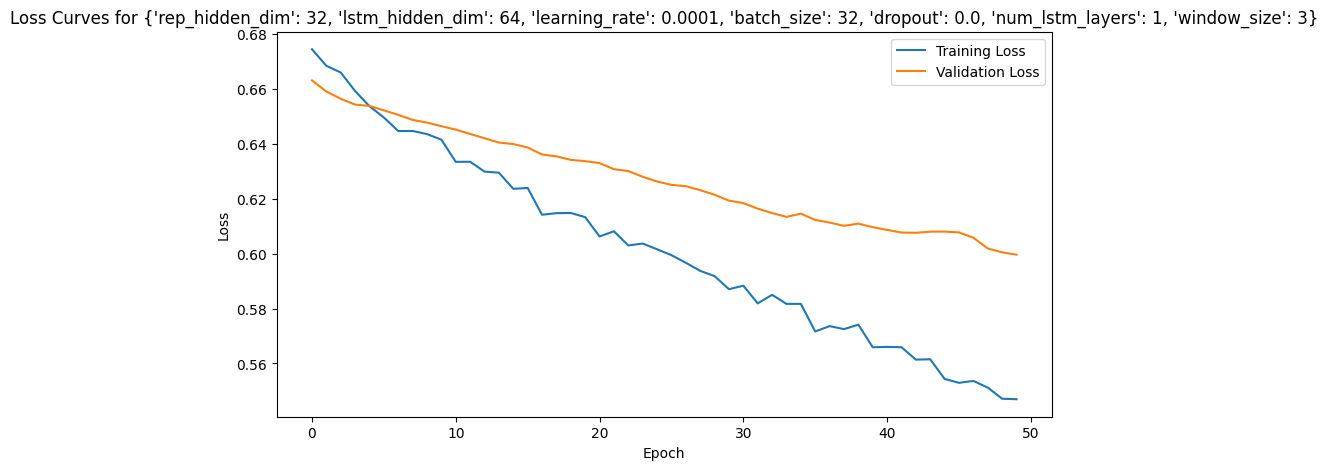

Testing config: {'rep_hidden_dim': 32, 'lstm_hidden_dim': 128, 'learning_rate': 0.0001, 'batch_size': 32, 'dropout': 0.0, 'num_lstm_layers': 1, 'window_size': 3}


KeyboardInterrupt: 

In [49]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

best_overall_loss = float('inf')
best_hparams = None
best_model_state = None

# BEST:
# Testing config: {'rep_hidden_dim': 64, 'lstm_hidden_dim': 128, 'learning_rate': 0.001, 'batch_size': 64, 'dropout': 0.0, 'num_lstm_layers': 1, 'window_size': 3}
# Testing config: {'rep_hidden_dim': 32, 'lstm_hidden_dim': 64, 'learning_rate': 0.001, 'batch_size': 32, 'dropout': 0.0, 'num_lstm_layers': 1, 'window_size': 5}

# BESTTT
# Testing config: {'rep_hidden_dim': 64, 'lstm_hidden_dim': 256, 'learning_rate': 0.0001, 'batch_size': 32, 'dropout': 0.0, 'num_lstm_layers': 1, 'window_size': 3}


for hparams in hyperparam_grid:
    print(f"Testing config: {hparams}")
    train_dataset = SlidingWindowRepDataset(train_data, balance_ratio=0.5, window_size=hparams['window_size'])
    val_dataset   = SlidingWindowRepDataset(val_data,   balance_ratio=0.5, window_size=hparams['window_size'])

    train_dataloader = DataLoader(train_dataset, batch_size=hparams['batch_size'], shuffle=True)
    val_dataloader   = DataLoader(val_dataset,   batch_size=hparams['batch_size'], shuffle=False)

    val_loss, model_state, train_losses, val_losses = train_and_eval(
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        frame_dim=7,
        rep_hidden_dim=hparams['rep_hidden_dim'],
        lstm_hidden_dim=hparams['lstm_hidden_dim'],
        learning_rate=hparams['learning_rate'],
        batch_size=hparams['batch_size'],
        dropout=hparams['dropout'],
        num_lstm_layers=hparams['num_lstm_layers'],
        num_epochs=50,
        patience=10,
        window_size=hparams['window_size'],
        device=device
    )

    print(f"Validation Loss = {val_loss:.4f}\n")

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'Loss Curves for {hparams}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    if val_loss < best_overall_loss:
        best_overall_loss = val_loss
        best_hparams = hparams
        best_model_state = model_state
        best_train_losses = train_losses
        best_val_losses = val_losses

print("Best hyperparameters:", best_hparams)
print("Best validation loss:", best_overall_loss)

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title(f'Loss Curves for {hparams}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

best_model = LSTMFailurePredictor(
    frame_dim=7,
    rep_hidden_dim=best_hparams['rep_hidden_dim'],
    lstm_hidden_dim=best_hparams['lstm_hidden_dim'],
    dropout=best_hparams['dropout'],
    num_lstm_layers=best_hparams['num_lstm_layers']
)
best_model.load_state_dict(best_model_state)
best_model.to(device)
best_model.eval()


In [34]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

test_dataset = SlidingWindowRepDataset(test_data, balance_ratio=0.5)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Ensure the model is on the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model.to(device)
best_model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for reps, labels in test_dataloader:
        reps, labels = reps.to(device), labels.to(device)  # Move data to the same device

        logits = best_model(reps)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).long()  # Convert probabilities to 0/1 predictions

        all_preds.extend(preds.cpu().numpy())  # Move back to CPU before converting to NumPy
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, zero_division=0)
recall = recall_score(all_labels, all_preds, zero_division=0)
f1 = f1_score(all_labels, all_preds, zero_division=0)

print(f"Test Accuracy:  {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall:    {recall:.4f}")
print(f"Test F1:        {f1:.4f}")


Test Accuracy:  0.8571
Test Precision: 0.9167
Test Recall:    0.7857
Test F1:        0.8462


In [35]:
import random
from collections import deque

# Online Inference (Step by Step)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model.to(device)
best_model.eval()
print(len(test_data))

window = deque(maxlen=3)  # Store last 3 reps

# Randomly select reps from the test set:
random_key = random.choice(list(test_data.keys()))
incoming_reps = np.stack(test_data[random_key], axis=0)  # Convert to NumPy array

print(f"Video set: {random_key}")
print("Total number of reps: ", len(incoming_reps))
for t, rep in enumerate(incoming_reps):  # Assume `incoming_reps` is streaming reps
    window.append(rep)  # No need to convert to numpy here

    if len(window) == 3:  # Only start predicting after 3 reps
        input_tensor = torch.tensor([list(window)], dtype=torch.float32).to(device)

        logit = best_model(input_tensor)  # Single prediction
        prob = torch.sigmoid(logit).item()  # Convert logit to probability

        print(f"Rep {t}: P(fail) = {prob:.4f}")

        if prob > 0.5:
            print(f"🔥 FAIL detected at rep {t}! Model stops.")
            break

29
Video set: 5_l.mp4_set_0
Total number of reps:  11
Rep 2: P(fail) = 0.3935
Rep 3: P(fail) = 0.4756
Rep 4: P(fail) = 0.4139
Rep 5: P(fail) = 0.3564
Rep 6: P(fail) = 0.3859
Rep 7: P(fail) = 0.3656
Rep 8: P(fail) = 0.1361
Rep 9: P(fail) = 0.4835
Rep 10: P(fail) = 0.7173
🔥 FAIL detected at rep 10! Model stops.


In [36]:
import torch
import numpy as np
from collections import deque

# Ensure model is on the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model.to(device)
best_model.eval()

distances = []
with torch.no_grad():
    for key, list_of_reps in test_data.items():
        # Check if list_of_reps is empty
        if not list_of_reps:
            print(f"Skipping video '{key}' because it has no reps.")
            continue  # Skip to the next video

        reps = np.stack(list_of_reps, axis=0)  # shape (R, 10, frame_dim)
        R = reps.shape[0]

        # If we have fewer than 3 reps, skip because our model needs 3 for the first prediction
        if R < 3:
            continue

        window = deque(maxlen=3)
        predicted_fail_idx = None  # Will store the index where model first says "fail"

        for t in range(R):
            rep = reps[t]
            window.append(rep)

            # Only start predicting once we have a full window of 3
            if len(window) == 3:
                input_tensor = torch.tensor([list(window)], dtype=torch.float32).to(device)  # Move to correct device

                logit = best_model(input_tensor)
                prob = torch.sigmoid(logit).item()

                if prob > 0.5:
                    predicted_fail_idx = t
                    break

        # The *actual* fail is the last rep in this sequence
        actual_fail_idx = R - 1

        # Compute the difference (pred - actual). If no fail predicted, store a large penalty
        if predicted_fail_idx is not None:
            dist = predicted_fail_idx - actual_fail_idx
        else:
            dist = None  # No prediction made

        distances.append(dist)

# Filter out any None distances (for sequences where no fail was predicted)
valid_distances = [d for d in distances if d is not None]

# Compute additional statistics if there are valid distances
if len(valid_distances) > 0:
    mean_distance = np.mean(valid_distances)
    median_distance = np.median(valid_distances)
    std_dev_distance = np.std(valid_distances)
    min_distance = np.min(valid_distances)
    max_distance = np.max(valid_distances)

    print("\n📊 **Failure Prediction Metrics** 📊")
    print(f"➡ Mean Distance:  {mean_distance:.4f}")
    print(f"➡ Median Distance: {median_distance:.4f}")
    print(f"➡ Std Deviation:  {std_dev_distance:.4f}")
    print(f"➡ Min Distance:   {min_distance}")
    print(f"➡ Max Distance:   {max_distance}")
    print("(Negative => model predicted failure before actual fail)")
else:
    print("No fail was ever predicted on the validation set (all predicted_fail_idx were None).")

Skipping video 'IMG_5794_cut.mov.mp4_set_0' because it has no reps.

📊 **Failure Prediction Metrics** 📊
➡ Mean Distance:  -2.9200
➡ Median Distance: -1.0000
➡ Std Deviation:  3.2732
➡ Min Distance:   -10
➡ Max Distance:   0
(Negative => model predicted failure before actual fail)
